## **Setup**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


## **Preparing Dataset**

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten labels
y_train, y_test = y_train.flatten(), y_test.flatten()


170498071/170498071 [==============================] - 3s 0us/step


## **Defining the models**

In [3]:
def build_classification_model():
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

def build_contrastive_model():
    base_model = build_classification_model()
    base_model.layers.pop()  # Remove the softmax layer
    outputs = base_model.layers[-1].output  # Last layer's output
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model


## **Contrastive Loss Function**

In [4]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.07, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def call(self, labels, feature_vectors):
        # Normalize the feature vectors
        normalized_vectors = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute the dot product between all vectors
        similarity_matrix = tf.matmul(normalized_vectors, normalized_vectors, transpose_b=True)
        # Scale similarity by temperature
        scaled_similarity_matrix = similarity_matrix / self.temperature
        # Create label matrix
        labels = tf.expand_dims(labels, 1)
        label_matrix = tf.equal(labels, tf.transpose(labels))
        label_matrix = tf.cast(label_matrix, tf.float32)

        # Apply the log-softmax function to each row of the scaled similarity matrix
        log_prob = tf.nn.log_softmax(scaled_similarity_matrix, axis=1)
        # Multiply log probabilities by the label matrix and sum over all entries
        loss = -tf.math.reduce_mean(tf.math.reduce_sum(tf.multiply(log_prob, label_matrix), axis=1))
        return loss


## **Training the models**

In [5]:
# Train Softmax Model
softmax_model = build_classification_model()
softmax_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
softmax_model.fit(x_train, y_train, epochs=10, validation_split=0.2)

# Train Contrastive Model
contrastive_model = build_contrastive_model()
contrastive_model.compile(optimizer='adam', loss=SupervisedContrastiveLoss())
# Training data needs to be duplicated to match loss function requirements
contrastive_model.fit(x_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
1250/1250 [==============================] - 48s 37ms/step - loss: 1.5583 - accuracy: 0.4338 - val_loss: 1.3506 - val_accuracy: 0.5283
Epoch 2/10
1250/1250 [==============================] - 51s 41ms/step - loss: 1.1795 - accuracy: 0.5829 - val_loss: 1.1330 - val_accuracy: 0.6085
Epoch 3/10
1250/1250 [==============================] - 49s 40ms/step - loss: 1.0428 - accuracy: 0.6360 - val_loss: 1.0999 - val_accuracy: 0.6230
Epoch 4/10
1250/1250 [==============================] - 50s 40ms/step - loss: 0.9557 - accuracy: 0.6675 - val_loss: 1.0109 - val_accuracy: 0.6482
Epoch 5/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.8902 - accuracy: 0.6912 - val_loss: 1.0097 - val_accuracy: 0.6491
Epoch 6/10
1250/1250 [==============================] - 49s 39ms/step - loss: 0.8342 - accuracy: 0.7090 - val_loss: 0.9479 - val_accuracy: 0.6746
Epoch 7/10
1250/1250 [==============================] - 49s 39ms/step - loss: 0.7845 - accuracy: 0.7268 - val_loss: 0.9605 -

## **Visualization of Embeddings**

In [6]:
import matplotlib.pyplot as plt

def visualize_embeddings(model_softmax, model_contrastive, data, labels):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Predict embeddings for softmax model
    intermediate_layer_model_softmax = tf.keras.Model(inputs=model_softmax.input,
                                                      outputs=model_softmax.get_layer('dense').output)
    embeddings_softmax = intermediate_layer_model_softmax.predict(data)
    tsne_softmax = TSNE(n_components=2, random_state=0)
    projections_softmax = tsne_softmax.fit_transform(embeddings_softmax)

    # Predict embeddings for contrastive model
    embeddings_contrastive = model_contrastive.predict(data)
    tsne_contrastive = TSNE(n_components=2, random_state=0)
    projections_contrastive = tsne_contrastive.fit_transform(embeddings_contrastive)

    # Plotting the softmax embeddings
    scatter1 = axes[0].scatter(projections_softmax[:, 0], projections_softmax[:, 1], c=labels, cmap='viridis', s=5)
    axes[0].set_title('Softmax Classification Embeddings')
    plt.colorbar(scatter1, ax=axes[0])  # Correctly adding colorbar

    # Plotting the contrastive embeddings
    scatter2 = axes[1].scatter(projections_contrastive[:, 0], projections_contrastive[:, 1], c=labels, cmap='viridis', s=5)
    axes[1].set_title('Contrastive Learning Embeddings')
    plt.colorbar(scatter2, ax=axes[1])  # Correctly adding colorbar

    plt.show()


313/313 [==============================] - 4s 13ms/step


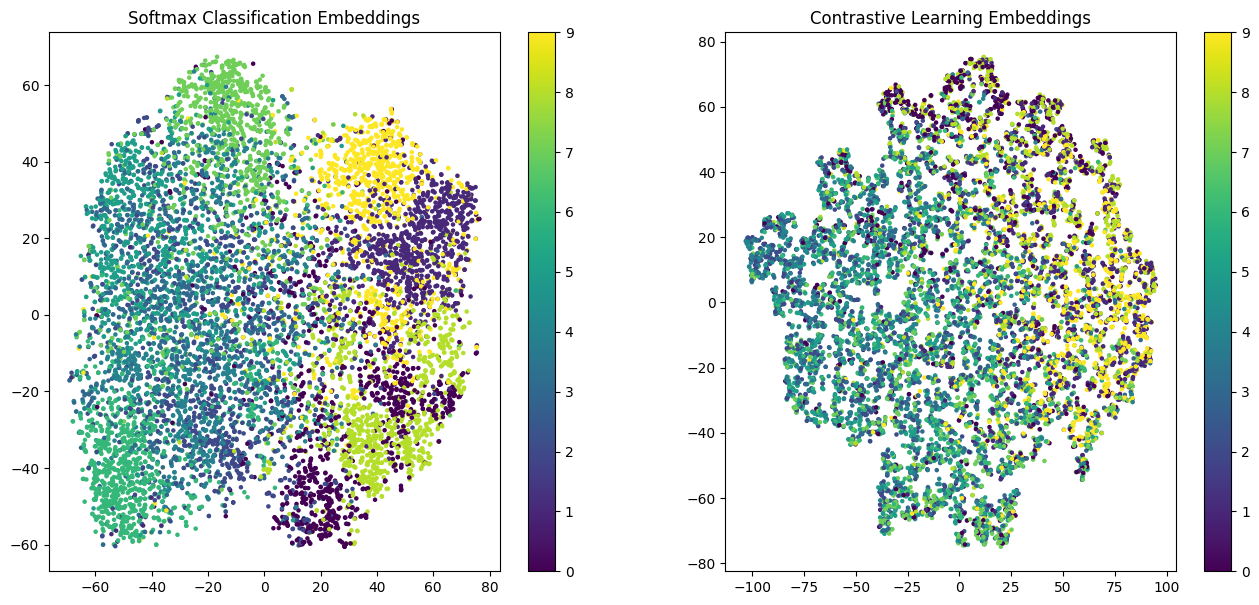

In [7]:
# After training both models:
visualize_embeddings(softmax_model, contrastive_model, x_test, y_test)
